# Error analysis

In [1]:
using NetCDF, PyPlot, ColorSchemes, Printf, Statistics, StatsBase, ProgressMeter
cmap = ColorMap(ColorSchemes.berlin.colors)

┌ Info: Precompiling ColorSchemes [35d6a980-a343-548e-a6ea-1d62b119f2f4]
└ @ Base loading.jl:1317


In [2]:
path = "/network/aopp/chaos/pred/kloewer/shallowwaters/isambard/"
ncfile = NetCDF.open(joinpath(path,"run0002","sst.nc"))
sst = ncfile.vars["sst"]
tdays = ncfile["t"][:] / 3600 / 24;   # in days

ncfile = NetCDF.open(joinpath(path,"run0002","u.nc"))
u = ncfile.vars["u"]

ncfile = NetCDF.open(joinpath(path,"run0002","eta.nc"))
eta = ncfile.vars["eta"]

Disk Array with size 3000 x 1500 x 302


In [3]:
ncfile = NetCDF.open(joinpath(path,"run0003","sst.nc"))
sst_uc = ncfile.vars["sst"]

ncfile = NetCDF.open(joinpath(path,"run0003","u.nc"))
u_uc = ncfile.vars["u"]

ncfile = NetCDF.open(joinpath(path,"run0003","eta.nc"))
eta_uc = ncfile.vars["eta"]

Disk Array with size 3000 x 1500 x 302


In [4]:
ncfile = NetCDF.open(joinpath(path,"run0004","sst.nc"))
sst64 = ncfile.vars["sst"]

ncfile = NetCDF.open(joinpath(path,"run0004","u.nc"))
u64 = ncfile.vars["u"]

ncfile = NetCDF.open(joinpath(path,"run0004","eta.nc"))
eta64 = ncfile.vars["eta"]

Disk Array with size 3000 x 1500 x 302


In [5]:
ncfile = NetCDF.open(joinpath(path,"run0005","sst.nc"))
sstm = ncfile.vars["sst"];

ncfile = NetCDF.open(joinpath(path,"run0005","u.nc"))
um = ncfile.vars["u"]

ncfile = NetCDF.open(joinpath(path,"run0005","eta.nc"))
etam = ncfile.vars["eta"]

Disk Array with size 3000 x 1500 x 302


In [11]:
# RMSE uncertainty by subsampling
nsamples = 100
nx,ny = 100,100   # size of subregion

rmse_comp_samples = fill(0.0,nsamples,length(tdays))
rmse_unco_samples = fill(0.0,nsamples,length(tdays))
rmse_mixd_samples = fill(0.0,nsamples,length(tdays))

@showprogress for n in 1:nsamples
    x0,y0 = rand(1:size(sst)[1]-nx),rand(1:size(sst)[2]-ny)
    x = x0:x0+nx-1
    y = y0:y0+ny-1
    
    u64_region = u64[x,y,:]
    rmse_comp_samples[n,:] = sqrt.(mean((u[x,y,:] .- u64_region).^2,dims=(1,2)))[1,1,:]
    rmse_unco_samples[n,:] = sqrt.(mean((u_uc[x,y,:] .- u64_region).^2,dims=(1,2)))[1,1,:]
    rmse_mixd_samples[n,:] = sqrt.(mean((um[x,y,:] .- u64_region).^2,dims=(1,2)))[1,1,:]
end

sort!(rmse_comp_samples,dims=1)
sort!(rmse_unco_samples,dims=1)
sort!(rmse_mixd_samples,dims=1);

Progress: 100%|█████████████████████████████████████████| Time: 0:12:20


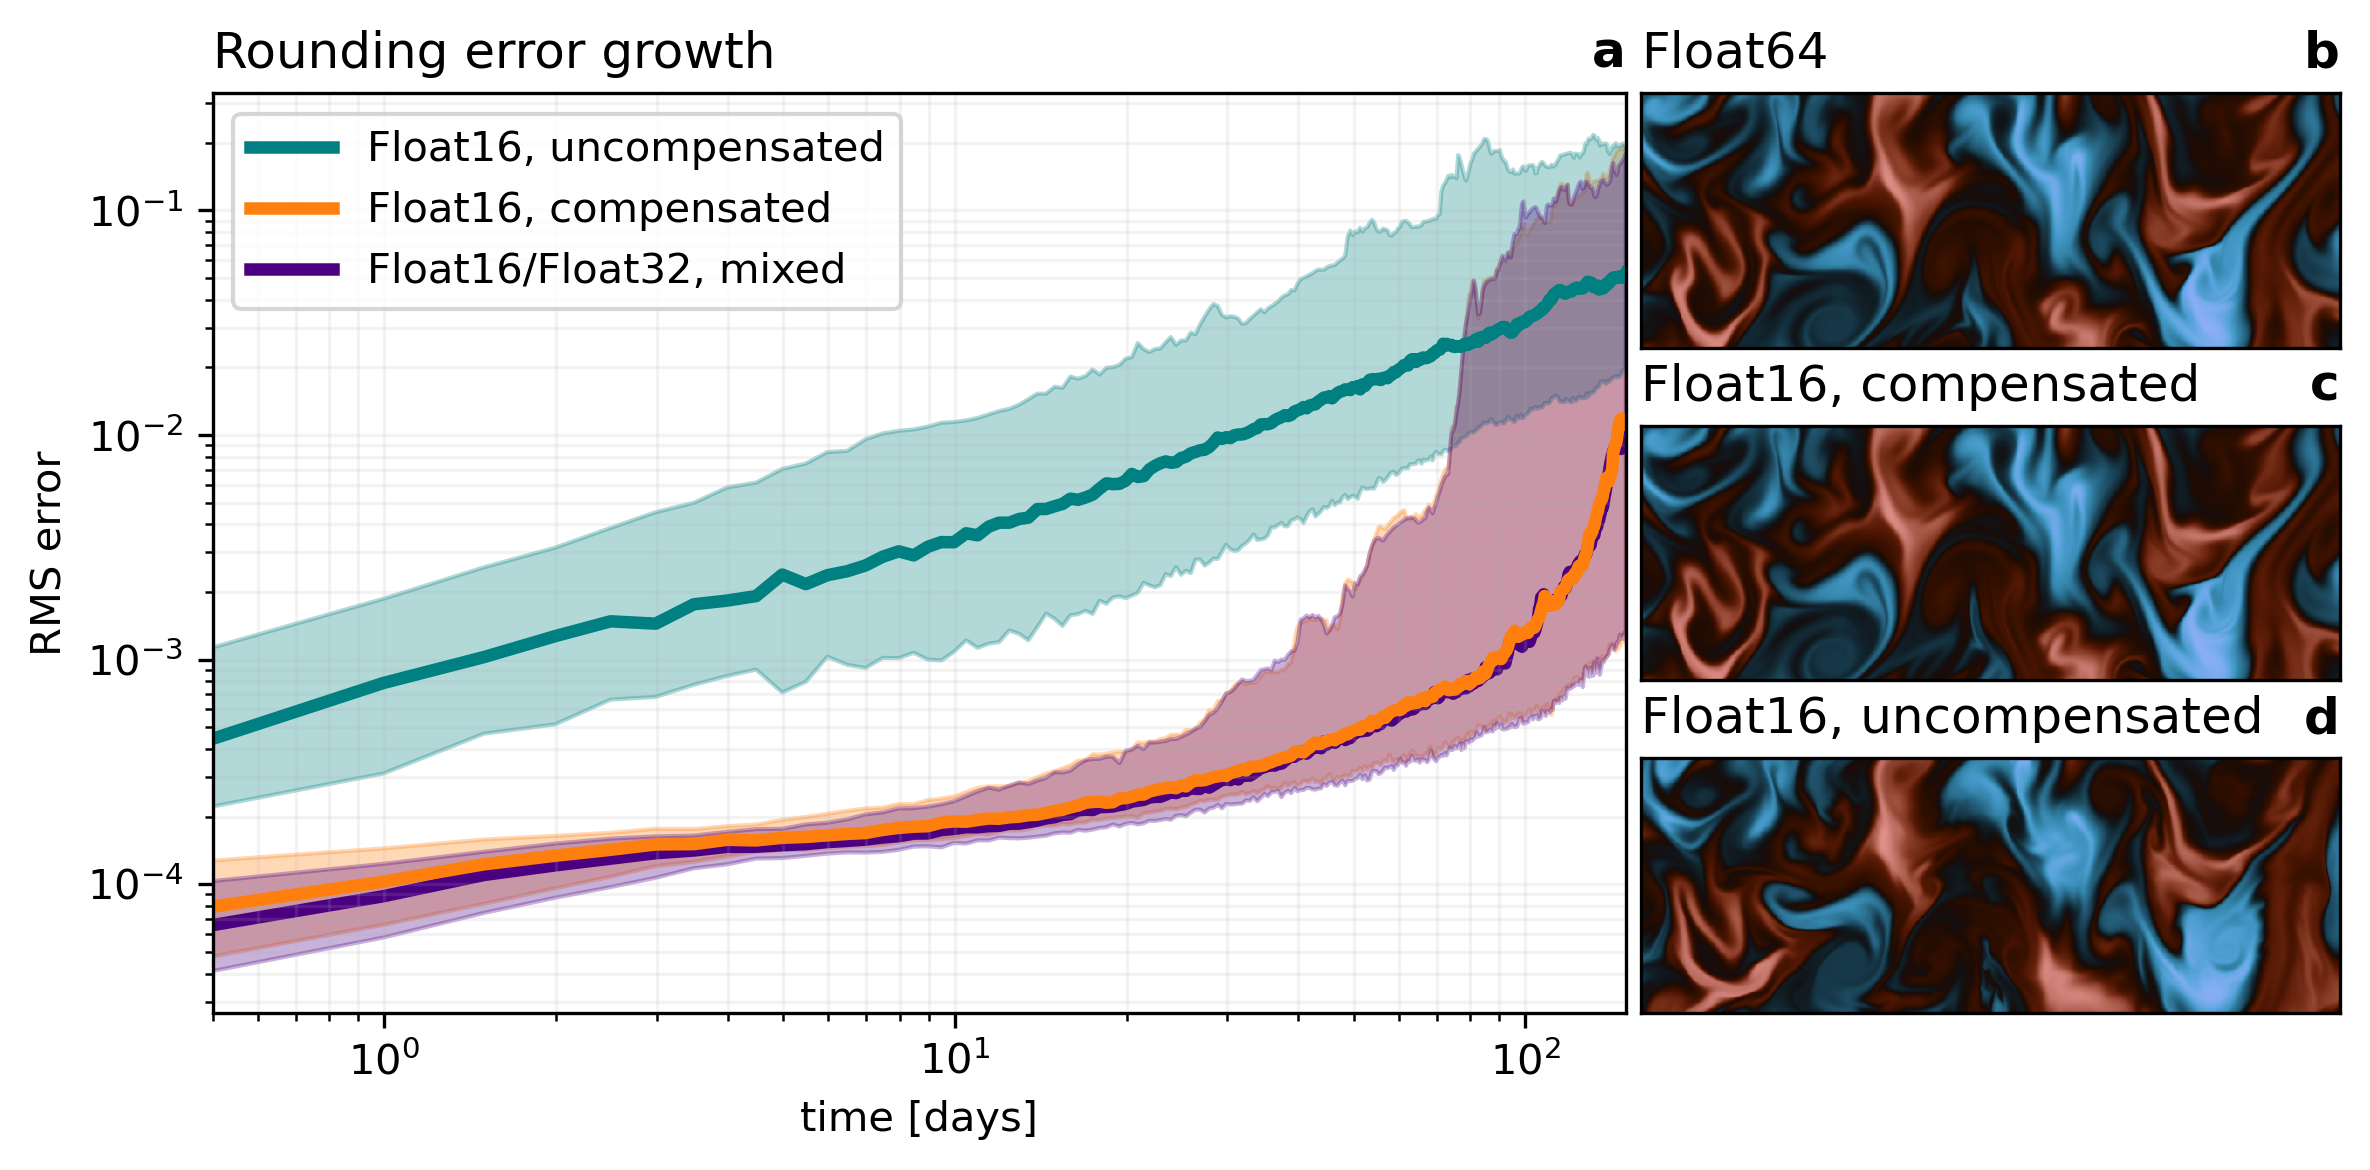

In [12]:
axes = plt.figure(figsize=(8,4),dpi=300).subplot_mosaic(
    """
    DDA
    DDB
    DDC
    """
)

ax1 = axes["A"]
ax2 = axes["B"]
ax3 = axes["C"]
ax4 = axes["D"]

ax4.loglog(tdays,rmse_unco_samples[nsamples÷2,:],"teal",lw=3,label="Float16, uncompensated")
ax4.loglog(tdays,rmse_comp_samples[nsamples÷2,:],"C1",lw=3,label="Float16, compensated")
ax4.loglog(tdays,rmse_mixd_samples[nsamples÷2,:],"indigo",zorder=1,lw=3,label="Float16/Float32, mixed")

ax4.fill_between(tdays,rmse_comp_samples[nsamples÷10,:],
                    rmse_comp_samples[9*(nsamples÷10),:],color="C1",alpha=0.3)
ax4.fill_between(tdays,rmse_unco_samples[nsamples÷10,:],
                    rmse_unco_samples[9*(nsamples÷10),:],color="teal",alpha=0.3)
ax4.fill_between(tdays,rmse_mixd_samples[nsamples÷10,:],
                    rmse_mixd_samples[9*(nsamples÷10),:],color="indigo",alpha=0.3)

tstep = 200
x0,x1 = 750,1550
y0,y1 = 400,700
ax1.pcolormesh(sst64[x0:x1,y0:y1,tstep]',cmap=cmap,vmin=-1,vmax=1,rasterized=true)
ax2.pcolormesh(sst[x0:x1,y0:y1,tstep]',cmap=cmap,vmin=-1,vmax=1,rasterized=true)
ax3.pcolormesh(sst_uc[x0:x1,y0:y1,tstep]',cmap=cmap,vmin=-1,vmax=1,rasterized=true)

for ax in [ax1,ax2,ax3]
    ax.set_xticks([])
    ax.set_yticks([])
end

for (iax,ax) in enumerate([ax4,ax1,ax2,ax3])
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
end


ax1.set_title("Float64",loc="left")
ax2.set_title("Float16, compensated",loc="left")
ax3.set_title("Float16, uncompensated",loc="left")
ax4.set_title("Rounding error growth",loc="left")

ax4.set_ylabel("RMS error")
ax4.set_xlabel("time [days]")
ax4.set_xlim(0.5,round(tdays[end]))

ax4.legend()
ax4.grid(alpha=0.15,which="both")

tight_layout(h_pad=0.01,w_pad=0.01)
savefig("error_growth.pdf")